# Generate Class Activation Map use VGG based model on the flower dataset
<br>

- Flower Dataset
https://drive.google.com/file/d/1HRTIVM6lyalQuF07V2eKywwMA5BJcSJh/view?usp=sharing
- VGG Pretrained weights
https://drive.google.com/open?id=1Hd2yvKke34rlkiCQ-P_V-wIU66eaGhiS

In [0]:
import os
import cPickle
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import time
import numpy as np
import pandas as pd
import skimage
import skimage.io
import skimage.transform
import tensorflow as tf
from tensorflow.python.client import device_lib

# Flower Dataset
dataset_path = '/content/flower_photos_new'
# VGG Pretrained weights
weight_path = '/content/caffe_layers_value.pickle'
# Model Path:
model_path = '/content/trained_models/'
saved_model_name = 'model-1'
saved_model_name_testing = 'model-1-1' 
# Pickle to be generated
trainset_path = '/content/datapickle/train.pickle'
testset_path = '/content/datapickle/test.pickle'
label_dict_path = '/content/datapickle/label_dict.pickle'

In [0]:
# Utils for loading imgs

def load_image( path ):
    try:
        img = skimage.io.imread( path )
    except:
        return None
      
    # convert to grey img
    img = skimage.color.rgb2lab(img)
    img[:,:,2] = 0
    img[:,:,1] = 0
    img = skimage.color.lab2rgb(img)

    if img is None: return None
    if len(img.shape) < 2: return None
    if len(img.shape) == 4: return None
    if len(img.shape) == 2: img=np.tile(img[:,:,None], 3)
    if img.shape[2] == 4: img=img[:,:,:3]
    if img.shape[2] > 4: return None
    
    # resize the image
    resized_img = skimage.transform.resize( img, [224,224] , mode='constant')
    
    return resized_img

In [0]:
# TF model

class Detector():
    def __init__(self, weight_file_path, n_labels):
        self.image_mean = [103.939, 116.779, 123.68]
        self.n_labels = n_labels

        with open(weight_file_path) as f:
            self.pretrained_weights = cPickle.load(f)

    def get_weight( self, layer_name):
        layer = self.pretrained_weights[layer_name]
        return layer[0]

    def get_bias( self, layer_name ):
        layer = self.pretrained_weights[layer_name]
        return layer[1]

    def get_conv_weight( self, name ):
        f = self.get_weight( name )
        return f.transpose(( 2,3,1,0 ))

    def conv_layer( self, bottom, name ):
        with tf.variable_scope(name) as scope:

            w = self.get_conv_weight(name)
            b = self.get_bias(name)

            conv_weights = tf.get_variable(
                    "W",
                    shape=w.shape,
                    initializer=tf.constant_initializer(w)
                    )
            conv_biases = tf.get_variable(
                    "b",
                    shape=b.shape,
                    initializer=tf.constant_initializer(b)
                    )

            conv = tf.nn.conv2d( bottom, conv_weights, [1,1,1,1], padding='SAME')
            bias = tf.nn.bias_add( conv, conv_biases )
            relu = tf.nn.relu( bias, name=name )

        return relu

    def new_conv_layer( self, bottom, filter_shape, name ):
        with tf.variable_scope( name ) as scope:
            w = tf.get_variable(
                    "W",
                    shape=filter_shape,
                    initializer=tf.random_normal_initializer(0., 0.01))
            b = tf.get_variable(
                    "b",
                    shape=filter_shape[-1],
                    initializer=tf.constant_initializer(0.))

            conv = tf.nn.conv2d( bottom, w, [1,1,1,1], padding='SAME')
            bias = tf.nn.bias_add(conv, b)

        return bias #relu

    def fc_layer(self, bottom, name, create=False):
        shape = bottom.get_shape().as_list()
        dim = np.prod( shape[1:] )
        x = tf.reshape(bottom, [-1, dim])

        cw = self.get_weight(name)
        b = self.get_bias(name)

        if name == "fc6":
            cw = cw.reshape((4096, 512, 7,7))
            cw = cw.transpose((2,3,1,0))
            cw = cw.reshape((25088,4096))
        else:
            cw = cw.transpose((1,0))

        with tf.variable_scope(name) as scope:
            cw = tf.get_variable(
                    "W",
                    shape=cw.shape,
                    initializer=tf.constant_initializer(cw))
            b = tf.get_variable(
                    "b",
                    shape=b.shape,
                    initializer=tf.constant_initializer(b))

            fc = tf.nn.bias_add( tf.matmul( x, cw ), b, name=scope)

        return fc

    def new_fc_layer( self, bottom, input_size, output_size, name ):
        shape = bottom.get_shape().to_list()
        dim = np.prod( shape[1:] )
        x = tf.reshape( bottom, [-1, dim])

        with tf.variable_scope(name) as scope:
            w = tf.get_variable(
                    "W",
                    shape=[input_size, output_size],
                    initializer=tf.random_normal_initializer(0., 0.01))
            b = tf.get_variable(
                    "b",
                    shape=[output_size],
                    initializer=tf.constant_initializer(0.))
            fc = tf.nn.bias_add( tf.matmul(x, w), b, name=scope)

        return fc

    def inference( self, rgb, train=False ):
        rgb *= 255.
        
        r, g, b = tf.split(rgb, num_or_size_splits=3, axis=3)
        bgr = tf.concat(
            [
                b-self.image_mean[0],
                g-self.image_mean[1],
                r-self.image_mean[2]
            ], axis=3)

        relu1_1 = self.conv_layer( bgr, "conv1_1" )
        relu1_2 = self.conv_layer( relu1_1, "conv1_2" )

        pool1 = tf.nn.max_pool(relu1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                         padding='SAME', name='pool1')

        relu2_1 = self.conv_layer(pool1, "conv2_1")
        relu2_2 = self.conv_layer(relu2_1, "conv2_2")
        pool2 = tf.nn.max_pool(relu2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool2')

        relu3_1 = self.conv_layer( pool2, "conv3_1")
        relu3_2 = self.conv_layer( relu3_1, "conv3_2")
        relu3_3 = self.conv_layer( relu3_2, "conv3_3")
        pool3 = tf.nn.max_pool(relu3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool3')

        relu4_1 = self.conv_layer( pool3, "conv4_1")
        relu4_2 = self.conv_layer( relu4_1, "conv4_2")
        relu4_3 = self.conv_layer( relu4_2, "conv4_3")
        pool4 = tf.nn.max_pool(relu4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool4')

        relu5_1 = self.conv_layer( pool4, "conv5_1")
        relu5_2 = self.conv_layer( relu5_1, "conv5_2")
        relu5_3 = self.conv_layer( relu5_2, "conv5_3")

        conv6 = self.new_conv_layer( relu5_3, [3,3,512,1024], "conv6")
        gap = tf.reduce_mean( conv6, [1,2] )

        with tf.variable_scope("GAP"):
            gap_w = tf.get_variable(
                    "W",
                    shape=[1024, self.n_labels],
                    initializer=tf.random_normal_initializer(0., 0.01))

        output = tf.matmul( gap, gap_w)

        return pool1, pool2, pool3, pool4, relu5_3, conv6, gap, output

    def get_classmap(self, label, conv6):
        conv6_resized = tf.image.resize_bilinear( conv6, [224, 224] )
        with tf.variable_scope("GAP", reuse=True):
            label_w = tf.gather(tf.transpose(tf.get_variable("W")), label)
            label_w = tf.reshape( label_w, [-1, 1024, 1] ) # [batch_size, 1024, 1]

        conv6_resized = tf.reshape(conv6_resized, [-1, 224*224, 1024]) # [batch_size, 224*224, 1024]

        classmap = tf.matmul( conv6_resized, label_w )
        
        classmap = tf.reshape( classmap, [-1, 224,224] )
        return classmap

In [0]:
# Creating/loading the datasets

if not os.path.exists( trainset_path ):
    print 'Starting to process the dataset and building the train, test, and label sets (only paths to the images) ...'
    image_dir_list = os.listdir( dataset_path )

    label_pairs = map(lambda x: x.split('.'), image_dir_list)
    print label_pairs
    labels, label_names = zip(*label_pairs)
    labels = map(lambda x: int(x), labels)

    label_dict = pd.Series( labels, index=label_names )
    label_dict -= 1
    n_labels = len( label_dict )

    image_paths_per_label = map(lambda one_dir: map(lambda one_file: os.path.join( dataset_path, one_dir, one_file ), os.listdir( os.path.join( dataset_path, one_dir))), image_dir_list)
    image_paths_train = np.hstack(map(lambda one_class: one_class[:-35], image_paths_per_label))
    image_paths_test = np.hstack(map(lambda one_class: one_class[-35:], image_paths_per_label))
    # set num of [test / train] = 35
    
    trainset = pd.DataFrame({'image_path': image_paths_train})
    testset  = pd.DataFrame({'image_path': image_paths_test })

    trainset = trainset[ trainset['image_path'].map( lambda x: x.endswith('.jpg'))]
    trainset['label'] = trainset['image_path'].map(lambda x: int(x.split('/')[-2].split('.')[0]) - 1)
    trainset['label_name'] = trainset['image_path'].map(lambda x: x.split('/')[-2].split('.')[1])

    testset = testset[ testset['image_path'].map( lambda x: x.endswith('.jpg'))]
    testset['label'] = testset['image_path'].map(lambda x: int(x.split('/')[-2].split('.')[0]) - 1)
    testset['label_name'] = testset['image_path'].map(lambda x: x.split('/')[-2].split('.')[1])

    label_dict.to_pickle(label_dict_path)
    trainset.to_pickle(trainset_path)
    testset.to_pickle(testset_path)
    print 'Processed the dataset and pickled to disk: trainset, testset, and label_dict'
else:
    trainset = pd.read_pickle( trainset_path )
    testset  = pd.read_pickle( testset_path )
    label_dict = pd.read_pickle( label_dict_path )
    print 'Read from disk: trainset, testset, and label_dict'
    n_labels = len(label_dict)


print 'Train set size: ' + str(len(trainset))
print 'Test set size: ' + str(len(testset))    

Starting to process the dataset and building the train, test, and label sets (only paths to the images) ...
[['005', 'tulips'], ['003', 'roses'], ['002', 'dandelion'], ['004', 'sunflowers'], ['001', 'daisy']]
Processed the dataset and pickled to disk: trainset, testset, and label_dict
Train set size: 3495
Test set size: 175


In [0]:
n_epochs = 2 # 10000
init_learning_rate = 0.01
weight_decay_rate = 0.0005
momentum = 0.9
batch_size = 60
max_iterations_per_epoch = -1 

now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_start = time.mktime(now.timetuple())

graph = tf.Graph()
with graph.as_default():
    learning_rate = tf.placeholder( tf.float32, [])
    images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
    labels_tf = tf.placeholder( tf.int64, [None], name='labels')

    detector = Detector(weight_path, n_labels)

    p1,p2,p3,p4,conv5, conv6, gap, output = detector.inference(images_tf)
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels_tf, logits=output))

    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
    weight_decay = tf.reduce_sum(tf.stack([tf.nn.l2_loss(x) for x in weights_only])) * weight_decay_rate

    loss_tf += weight_decay

    saver = tf.train.Saver( max_to_keep=50 )

    optimizer = tf.train.MomentumOptimizer( learning_rate, momentum )
    grads_and_vars = optimizer.compute_gradients( loss_tf )
    grads_and_vars = map(lambda gv: (gv[0], gv[1]) if ('conv6' in gv[1].name or 'GAP' in gv[1].name) else (gv[0]*0.1, gv[1]), grads_and_vars)
    #grads_and_vars = [(tf.clip_by_value(gv[0], -5., 5.), gv[1]) for gv in grads_and_vars]
    train_op = optimizer.apply_gradients( grads_and_vars )
    
with tf.Session(graph=graph) as sess:    
    tf.global_variables_initializer().run()

    if pretrained_model:
        print 'Pretrained model loaded from ' + pretrained_model + ' (this overwrites the initial weights loaded to the model)'
        saver.restore(sess, pretrained_model)

    testset.index  = range( len(testset) )

    iterations = 0
    loss_list = []
    print 'Starting the training ...'
    for epoch in range(n_epochs):
        trainset.index = range( len(trainset) )
        trainset = trainset.loc[ np.random.permutation( len(trainset) )]

        for start, end in zip(
            range( 0, len(trainset)+batch_size, batch_size),
            range(batch_size, len(trainset)+batch_size, batch_size)):

            current_data = trainset[start:end]
            current_image_paths = current_data['image_path'].values
            current_images = np.array(map(lambda x: load_image(x), current_image_paths))

            good_index = np.array(map(lambda x: x is not None, current_images))

            current_data = current_data[good_index]
            current_images = np.stack(current_images[good_index])
            current_labels = current_data['label'].values

            _, loss_val, output_val = sess.run(
                    [train_op, loss_tf, output],
                    feed_dict={
                        learning_rate: init_learning_rate,
                        images_tf: current_images,
                        labels_tf: current_labels
                        })

            loss_list.append( loss_val )

            iterations += 1
            if iterations % 5 == 0:
                print "======================================"
                print "Epoch", epoch + 1, "Iteration", iterations
                print "Processed", start, '/', len(trainset)

                label_predictions = output_val.argmax(axis=1)
                acc = (label_predictions == current_labels).sum()

                print "Accuracy:", acc, '/', len(current_labels)
                print "Training Loss:", np.mean(loss_list)
                #print "\n"
                loss_list = []

            if iterations > max_iterations_per_epoch and max_iterations_per_epoch != -1:
                iterations = 0
                break

        n_correct = 0
        n_data = 0
        for start, end in zip(
                range(0, len(testset)+batch_size, batch_size),
                range(batch_size, len(testset)+batch_size, batch_size)
                ):
            current_data = testset[start:end]
            current_image_paths = current_data['image_path'].values
            current_images = np.array(map(lambda x: load_image(x), current_image_paths))

            good_index = np.array(map(lambda x: x is not None, current_images))

            current_data = current_data[good_index]
            current_images = np.stack(current_images[good_index])
            current_labels = current_data['label'].values

            output_vals = sess.run(
                    output,
                    feed_dict={images_tf:current_images})

            label_predictions = output_vals.argmax(axis=1)
            acc = (label_predictions == current_labels).sum()

            n_correct += acc
            n_data += len(current_data)

        acc_all = n_correct / float(n_data)
        print "$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$"
        print 'Model evaluation on the test set:'
        print 'Epoch:'+str(epoch + 1)+'\tacc:'+str(acc_all)
        print "$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$"

        saver.save( sess, os.path.join( model_path, saved_model_name), global_step=epoch)

        init_learning_rate *= 0.99
    
now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_end = time.mktime(now.timetuple())
print 'Processing took ' + str( np.around( (seconds_since_epoch_end - seconds_since_epoch_start)/60.0 , decimals=1) ) + ' minutes.'

Starting the training ...
Epoch 1 Iteration 5
Processed 240 / 3495
Accuracy: 45 / 60
Training Loss: 1.594157
Epoch 1 Iteration 10
Processed 540 / 3495
Accuracy: 35 / 60
Training Loss: 1.9056364
Epoch 1 Iteration 15
Processed 840 / 3495
Accuracy: 45 / 60
Training Loss: 1.5694003
Epoch 1 Iteration 20
Processed 1140 / 3495
Accuracy: 38 / 60
Training Loss: 1.3797243
Epoch 1 Iteration 25
Processed 1440 / 3495
Accuracy: 43 / 60
Training Loss: 1.2299601
Epoch 1 Iteration 30
Processed 1740 / 3495
Accuracy: 39 / 60
Training Loss: 1.1828321
Epoch 1 Iteration 35
Processed 2040 / 3495
Accuracy: 45 / 60
Training Loss: 1.2002912
Epoch 1 Iteration 40
Processed 2340 / 3495
Accuracy: 41 / 60
Training Loss: 1.0690486
Epoch 1 Iteration 45
Processed 2640 / 3495
Accuracy: 48 / 60
Training Loss: 1.2063005
Epoch 1 Iteration 50
Processed 2940 / 3495
Accuracy: 49 / 60
Training Loss: 1.0851228
Epoch 1 Iteration 55
Processed 3240 / 3495
Accuracy: 42 / 60
Training Loss: 1.2416341
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

roses
['/content/flower_photos_new/003.roses/003_0070.jpg']


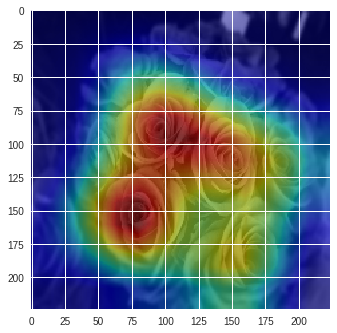

tulips
['/content/flower_photos_new/005.tulips/005_0510.jpg']


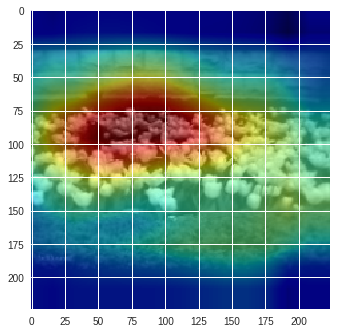

dandelion
['/content/flower_photos_new/002.dandelion/002_0408.jpg']


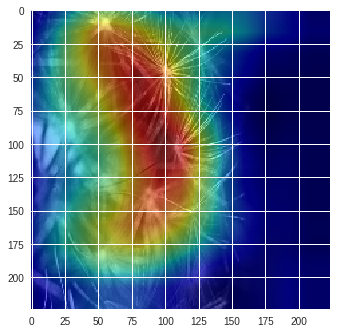

sunflowers
['/content/flower_photos_new/004.sunflowers/004_0489.jpg']


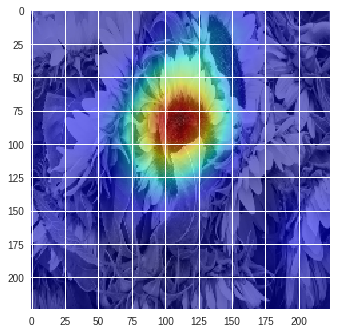

sunflowers
['/content/flower_photos_new/004.sunflowers/004_0330.jpg']


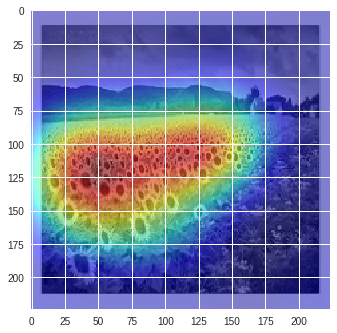

tulips
['/content/flower_photos_new/005.tulips/005_0186.jpg']


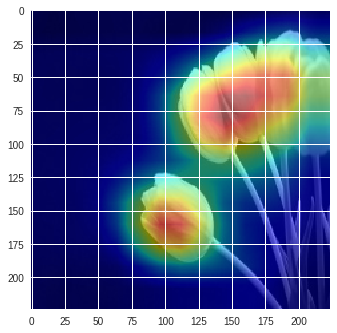

tulips
['/content/flower_photos_new/005.tulips/005_0647.jpg']


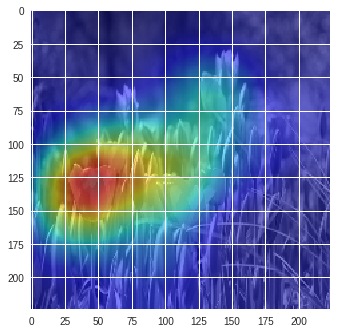

dandelion
['/content/flower_photos_new/002.dandelion/002_0618.jpg']


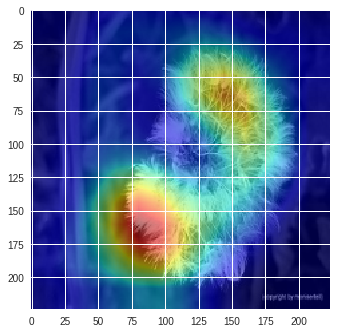

dandelion
['/content/flower_photos_new/002.dandelion/002_0650.jpg']


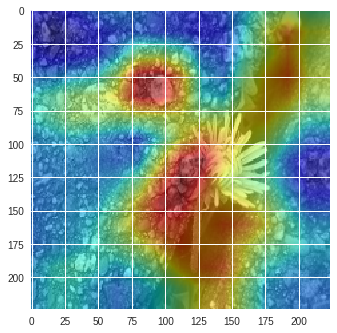

In [0]:
# Generate the Class Activation Map

from copy import copy
# Reading the testset, creating the graph, and restoring the trained model:

num_cam_images = 10 # Number of images randomly selected for which we are producing the CAM

batch_size = 1

#generate for testsets
testset = pd.read_pickle( testset_path )
#generate for trainsets
#testset = pd.read_pickle( trainset_path ) #[::-1][:20]
label_dict = pd.read_pickle( label_dict_path )
n_labels = len( label_dict )

random_selection = np.random.randint(0, len(testset) - batch_size , size=num_cam_images)

# generate all results
# all_selection = np.array([x for x in range(0,len(testset))])
# random_selection = all_selection

heat_maps = []

graph = tf.Graph()
with graph.as_default():
    images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
    labels_tf = tf.placeholder( tf.int64, [None], name='labels')

    detector = Detector( weight_path, n_labels )
    c1,c2,c3,c4,conv5, conv6, gap, output = detector.inference( images_tf )

    saver = tf.train.Saver()
    
    classmap = detector.get_classmap( labels_tf, conv6 )

with tf.Session(graph=graph) as sess:    
    
    saver.restore( sess, os.path.join( model_path, saved_model_name_testing) )

    for start, end in zip(
        random_selection,
        list(random_selection + batch_size)):
        '''
        range( 0, len(testset)+batch_size, batch_size),
        range(batch_size, len(testset)+batch_size, batch_size)):

        if end >= num_cam_images:
            break
        '''

        current_data = testset[start:end]
        current_image_paths = current_data['image_path'].values
        current_images = np.array(map(lambda x: load_image(x), current_image_paths))

        good_index = np.array(map(lambda x: x is not None, current_images))

        current_data = current_data[good_index]
        current_image_paths = current_image_paths[good_index]
        current_images = np.stack(current_images[good_index])
        current_labels = current_data['label'].values
        current_label_names = current_data['label_name'].values

        conv6_val, output_val = sess.run(
                [conv6, output],
                feed_dict={
                    images_tf: current_images
                    })

        label_predictions = output_val.argmax( axis=1 )
        acc = (label_predictions == current_labels).sum()

        classmap_vals = sess.run(
                classmap,
                feed_dict={
                    labels_tf: label_predictions,
                    conv6: conv6_val
                    })

        classmap_answer = sess.run(
                classmap,
                feed_dict={
                    labels_tf: current_labels,
                    conv6: conv6_val
                    })

        classmap_vis = map(lambda x: ((x-x.min())/(x.max()-x.min())), classmap_answer)
        
        print "======================================"
        for vis, ori,ori_path, l_name in zip(classmap_vis, current_images, current_image_paths, current_label_names):
            print l_name
            print current_image_paths
            plt.imshow( ori )
            plt.imshow( vis, cmap=plt.cm.jet, alpha=0.5, interpolation='nearest' )
            plt.show()
            encoded_vis = cPickle.dumps(copy(vis))
            heat_maps.append(encoded_vis)

#print heat_maps

In [0]:
# save all heatmaps into data pickles
print len(heat_maps)
testdf = copy(testset)
testdf['heatmap'] = pd.Series(heat_maps, index=testdf.index)
testdf.to_pickle("/content/trainset-final.pickle")

3495
